In [1]:
import numpy as np
import scipy.linalg
import scipy.io
import itertools
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit.extensions import UnitaryGate

# custom utility functions
from util import *
from qetu import *
from tfim import *
from fermi_hubbard import *
from wmi_backend import *

### Test TFIM Implementation

In [2]:
delta_t = 1
tfim = TFIM(4, 1.43535)
H = tfim.Hamiltonian
U = expm(-1j*delta_t*H)

qc = tfim.Trotterization(delta_t, 100)
trotter = get_matrix(qc)

print("second order Trotter error {:.5e}".format(np.linalg.norm(U - trotter, 2)))

ctrl_U = scipy.linalg.block_diag(U.conjugate().transpose(), U)
ctrl_free_qc = tfim.Trotterization(delta_t, 100, True)
ctrl_free_trotter = get_matrix(ctrl_free_qc)

print("controlled Trotter error {:.5e}".format(np.linalg.norm(ctrl_U - ctrl_free_trotter, 2)))

second order Trotter error 1.93438e-04
controlled Trotter error 1.93438e-04


### Test Fermi Hubbard Implementation

In [3]:
delta_t = 1
fh = FermiHubbard(2, 0.5, 6, 1)
H = fh.Hamiltonian
U = expm(-1j*delta_t*H)

qc = fh.Trotterization(delta_t, 100)
trotter = get_matrix(qc)

print("second order Trotter error {:.5e}".format(np.linalg.norm(U - trotter, 2)))

ctrl_U = scipy.linalg.block_diag(U.conjugate().transpose(), U)
ctrl_free_qc = fh.Trotterization(delta_t, 100, True)
ctrl_free_trotter = get_matrix(ctrl_free_qc)

print("controlled Trotter error {:.5e}".format(np.linalg.norm(ctrl_U - ctrl_free_trotter, 2)))

second order Trotter error 1.26480e-03
controlled Trotter error 1.26480e-03


#### Trotter Convergence Test

In [4]:
t = 1
step_size_list = [2**x for x in range(20)]
delta_t_list = []
fh_error_list = []
tfim_error_list = []
ctrl_tfim_error_list = []
ctrl_fh_error_list = []
for T in step_size_list:
    delta_t = t / T
    # TFIM
    tfim = TFIM(4, 1.43535)
    H_TFIM = tfim.Hamiltonian
    U_TFIM = expm(-1j*delta_t*H_TFIM)
    tfim_qc = tfim.Trotterization(delta_t, 100)
    tfim_trotter = get_matrix(tfim_qc)
    tfim_error = np.linalg.norm(U_TFIM - tfim_trotter, 2)
    tfim_error_list.append(tfim_error)
    # controlled TFIM
    ctrl_U_TFIM = scipy.linalg.block_diag(U_TFIM.conjugate().transpose(), U_TFIM)
    tfim_ctrl_free_qc = tfim.Trotterization(delta_t, 100, True)
    tfim_ctrl_free_trotter = get_matrix(tfim_ctrl_free_qc)
    ctrl_tfim_error = np.linalg.norm(ctrl_U_TFIM - tfim_ctrl_free_trotter, 2)
    ctrl_tfim_error_list.append(ctrl_tfim_error)
    # Fermi Hubbard
    fh = FermiHubbard(2, 0.5, 6, 1)
    H_FH = fh.Hamiltonian
    U_FH = expm(-1j*delta_t*H_FH)
    fh_qc = fh.Trotterization(delta_t, 100)
    fh_trotter = get_matrix(fh_qc)
    fh_error = np.linalg.norm(U_FH - fh_trotter, 2)
    fh_error_list.append(fh_error)
    # controlled FH
    ctrl_U_FH = scipy.linalg.block_diag(U_FH.conjugate().transpose(), U_FH)
    fh_ctrl_free_qc = fh.Trotterization(delta_t, 100, True)
    fh_ctrl_free_trotter = get_matrix(fh_ctrl_free_qc)
    ctrl_fh_error = np.linalg.norm(ctrl_U_FH - fh_ctrl_free_trotter, 2)
    ctrl_fh_error_list.append(ctrl_fh_error)

    delta_t_list.append(delta_t)

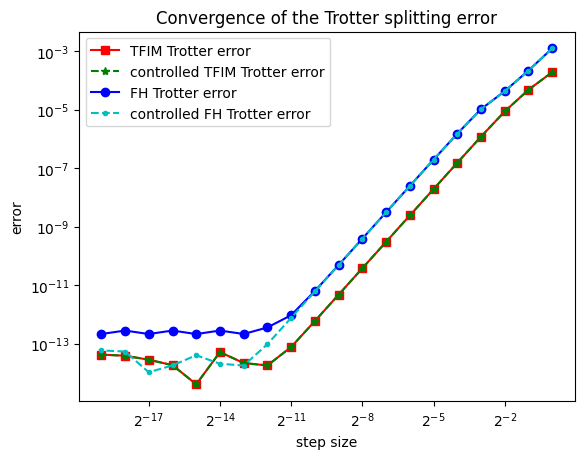

In [5]:
plt.loglog(delta_t_list, tfim_error_list, linestyle='-', marker='s', color='r', label='TFIM Trotter error')
plt.loglog(delta_t_list, ctrl_tfim_error_list, linestyle='--', marker='*', color='g', label='controlled TFIM Trotter error')
plt.loglog(delta_t_list, fh_error_list, linestyle='-', marker='o', color='b', label='FH Trotter error')
plt.loglog(delta_t_list, ctrl_fh_error_list, linestyle='--', marker='.', color='c', label='controlled FH Trotter error')
plt.xlabel("step size")
plt.ylabel("error")
plt.xscale("log", base=2)
plt.yscale("log",base=10)
plt.title("Convergence of the Trotter splitting error")
plt.legend()

### Test QSP Implementation

In [3]:
mat_step_func = scipy.io.loadmat('phase_angles/step_function.mat')['phi_proc']
step_function_qsp_angles = list(itertools.chain.from_iterable(mat_step_func))

mat_cheb_ex4 = scipy.io.loadmat('phase_angles/chebyshev_ex4.mat')['phi_proc']
cheb_ex4_qsp_angles = list(itertools.chain.from_iterable(mat_cheb_ex4))

C:\Users\thilo\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


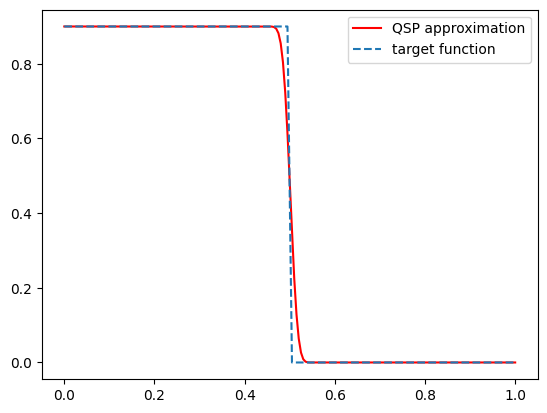

In [4]:
def target_heaviside(x, scale=1):
    """
        Target function for eigenvalue filtering.
    """
    return scale * np.heaviside(-x+0.5, 0.5)

x_vec = np.linspace(0, 1, 201)
y_vec = []
for x in x_vec:
    qsp_circuit = QSP(step_function_qsp_angles, x)
    y = get_matrix(qsp_circuit)[0,0]
    y_vec.append(y)

plt.plot(x_vec, y_vec, "r", label="QSP approximation")
plt.plot(x_vec, target_heaviside(x_vec, scale=0.9), "--", label="target function")
plt.legend()

### Test QETU Implementation

In [5]:
H = np.diag(np.array([np.arccos(0.1), np.arccos(0.3), np.arccos(0.6), np.arccos(0.9)]))
array_to_latex(H)

<IPython.core.display.Latex object>

In [6]:
U = expm(-1j*H)
V = scipy.linalg.block_diag(U.conjugate().transpose(), U)
V_gate = UnitaryGate(V)
q = QuantumRegister(3, 'q')
V_qc = QuantumCircuit(q)
V_qc.append(V_gate, q)

expected eigenvalues: [0.9 0.9 0.  0. ]
actual eigenvalues: [ 0.70278405 -0.17856548  0.36304686 -0.36821494]


Text(0, 0.5, 'U = F(cos(λ))')

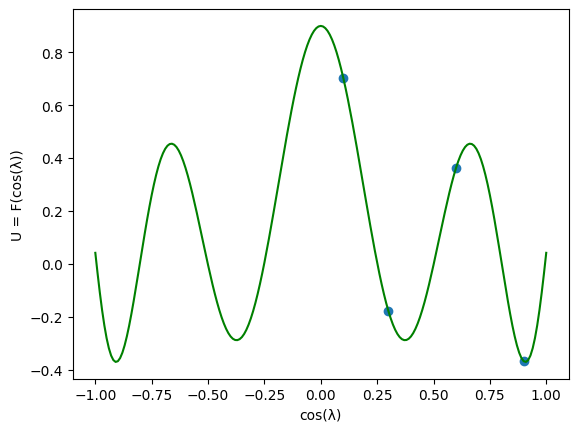

In [7]:
U_qc = QETU(V_qc, convert_Zrot_to_Xrot(cheb_ex4_qsp_angles))
U_qetu = get_matrix(U_qc)[0:4, 0:4]
λ = np.linalg.eigvals(H)
expected_eigenvalues = target_heaviside(np.cos(λ.real), 0.9)
print("expected eigenvalues: " + str(expected_eigenvalues))
F_λ = np.linalg.eigvals(U_qetu).real * -1
print("actual eigenvalues: " + str(F_λ))

x_list = np.linspace(-1, 1, 201)
QSP_list = []
for x in x_list:
    QSP_circuit = QSP(cheb_ex4_qsp_angles, x)
    result = get_matrix(QSP_circuit)[0,0]
    QSP_list.append(result)

#plt.plot(x_list, target_filt(x_list, scale=0.9), "--", label="target function")
plt.plot(x_list, QSP_list, "g", label="Re[Poly(a)]")
#plt.scatter(x=np.cos(λ), y=expected_eigenvalues, color='r')
plt.scatter(x=np.cos(λ), y=F_λ)
plt.xlabel("cos(λ)")
plt.ylabel("U = F(cos(λ))")

#### QETU Hardware Implementation

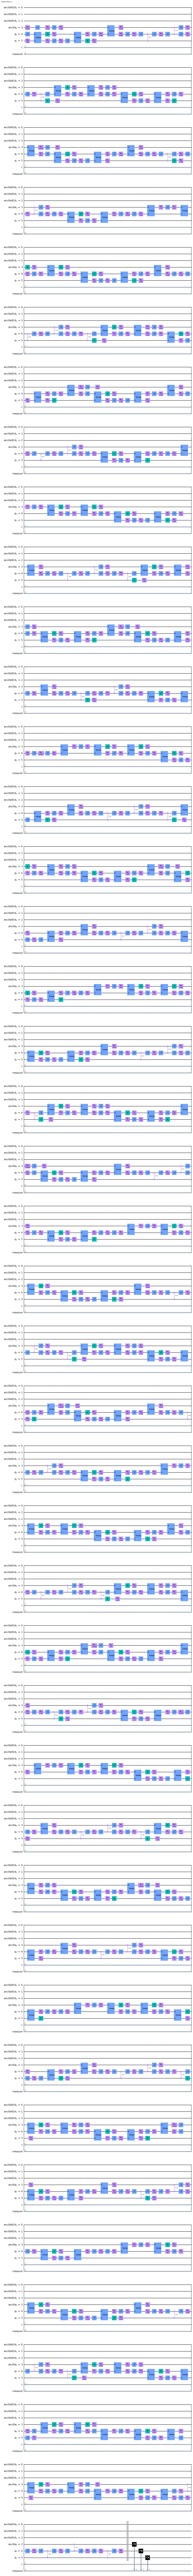

In [8]:
from wmi_backend import *

# Transpile to WMI hardware
test_circ = transpile(
    U_qc,
    backend=backend,
    optimization_level=3
)
test_circ.measure_active()
test_circ.draw("mpl")

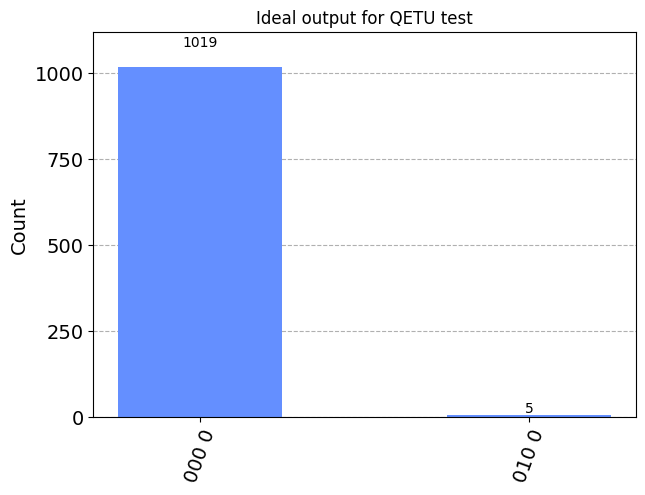

In [9]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for QETU test')

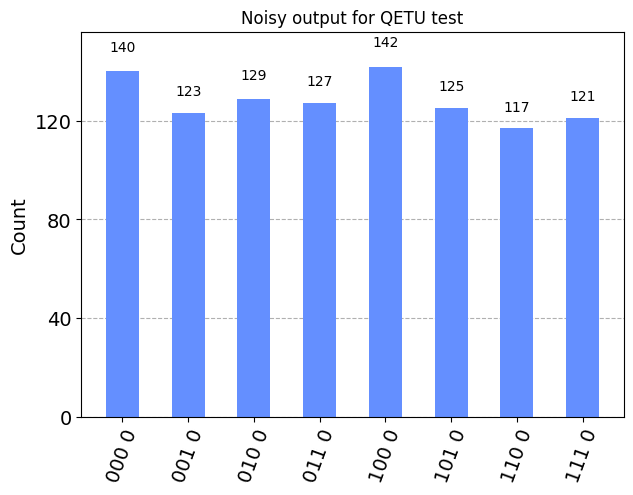

In [10]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for QETU test')

### Test QETU with TFIM

In [11]:
delta_t = 1
tfim = TFIM(3, 1.4)
H = tfim.Hamiltonian
H = transform_eigenvals(H)
U = expm(-1j*delta_t*H)
V = tfim.Trotterization(delta_t, 100, True)

actual eigenvalues: [-2.13821831e-08-0.92676769j  8.26892825e-10-0.99987343j
  8.26899432e-10+0.99987343j -2.13821902e-08+0.92676769j
  8.99999979e-01+0.43561806j  8.99999979e-01-0.43561806j
  8.99999943e-01-0.39139172j  8.99999943e-01+0.39139172j]


C:\Users\thilo\AppData\Roaming\Python\Python311\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, 'F(cos(λ))')

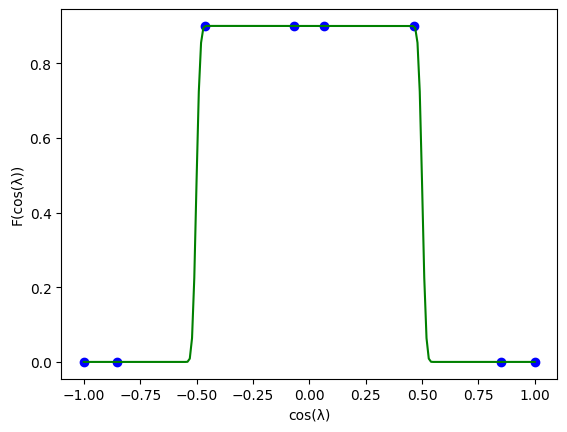

In [12]:
U_qc = get_matrix(QETU(V, convert_Zrot_to_Xrot(step_function_qsp_angles)))[0:8,0:8]

λ, v = np.linalg.eig(H)
eigenvalues = λ

F_λ, F_v = np.linalg.eig(U_qc)
actual_eigenvalues = F_λ * (-1)
print("actual eigenvalues: " + str(actual_eigenvalues))

x_list = np.linspace(-1, 1, 201)
QSP_list = []
for x in x_list:
    QSP_circuit = QSP(step_function_qsp_angles, x)
    result = get_matrix(QSP_circuit)[0,0]
    QSP_list.append(result)

plt.plot(x_list, QSP_list, color='g', label="expected function")
plt.scatter(x=np.cos(eigenvalues), y=actual_eigenvalues, color='b')

plt.xlabel("cos(λ)")
plt.ylabel("F(cos(λ))")

### Test QETU with Fermi Hubbard

In [13]:
delta_t = 1
fh = FermiHubbard(2, 0.5, 7, 1)
H = fh.Hamiltonian

Δ = spectral_gap(H)
λ, v = np.linalg.eig(H)
λ_min = λ.min()
λ_max = λ.max()

η = Δ # distance
c1 = (np.pi - 2*η) / (λ_max - λ_min)
c2 = η - c1 * λ_min

H_sh = c1*H + c2*np.eye(H.shape[0])

delta_t_sh = delta_t * c1
shift = delta_t * c2

U = expm(-1j*delta_t*H_sh)
V_ref = scipy.linalg.block_diag(U.conjugate().transpose(), U)
V = fh.Trotterization(delta_t, 1, True)

In [14]:
V_gate = UnitaryGate(V_ref)
q = QuantumRegister(5, 'q')
V_qc = QuantumCircuit(q)
V_qc.append(V_gate, q)

actual eigenvalues: [-6.06265449e-08+0.26963102j  8.99999953e-01+0.3781795j
 -1.10177045e-08+0.96452685j  8.99999941e-01+0.32017064j
 -1.10177045e-08+0.96452685j  8.99999941e-01+0.32017064j
  3.16305767e-08+0.91210438j  8.99999942e-01-0.09041051j
  5.96834837e-08+0.01111727j -6.06265450e-08+0.26963102j
  8.99999940e-01+0.38770411j  8.99999953e-01+0.3781795j
  5.96834840e-08-0.01111727j  8.99999940e-01+0.38770411j
  8.99999940e-01+0.38770411j  8.99999969e-01-0.3509667j ]


Text(0, 0.5, 'F(cos(λ))')

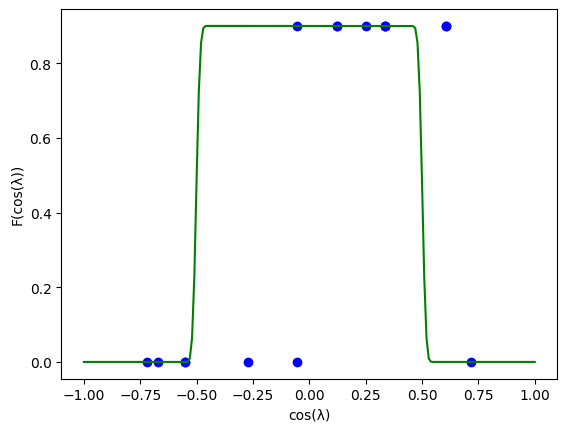

In [15]:
U_qc = get_matrix(QETU(V_qc, convert_Zrot_to_Xrot(step_function_qsp_angles)))[0:16,0:16]
U = U_qc @ expm(-1j*delta_t*c2*np.eye(16))

λ, v = np.linalg.eig(H_sh)
eigenvalues = λ

F_λ, F_v = np.linalg.eig(U_qc)
actual_eigenvalues = F_λ * (-1)
print("actual eigenvalues: " + str(actual_eigenvalues))

x_list = np.linspace(-1, 1, 201)
QSP_list = []
for x in x_list:
    QSP_circuit = QSP(step_function_qsp_angles, x)
    result = get_matrix(QSP_circuit)[0,0]
    QSP_list.append(result)

plt.scatter(x=np.cos(eigenvalues), y=actual_eigenvalues, color='b')
plt.plot(x_list, QSP_list, "g", label="Re[Poly(a)]")


plt.xlabel("cos(λ)")
plt.ylabel("F(cos(λ))")

### Test QETU Ground State Estimation

In [16]:
delta_t = 0.00012345
fh = FermiHubbard(2, 2.343, 3.4534, 9.343)
H = fh.Hamiltonian
U = expm(-1j*delta_t*H)

# Diagonalize the Hamiltonian
λ, v = np.linalg.eigh(H)
# Find the ground state
ground_state_index = np.argmin(λ)
ground_state_energy = λ[ground_state_index]
ground_state_vector = v[:, ground_state_index]

print("Ground state energy:", ground_state_energy)
print("Ground state vector:", ground_state_vector)

Ground state energy: -74.76394203685355
Ground state vector: [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j -4.94192433e-01+0.j
 -5.05740882e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -5.05740882e-01+0.j -4.94192433e-01+0.j -4.43176409e-17+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j]


In [17]:
V = fh.Trotterization(delta_t, 100, True)
qetu_cirtuit = QETU(V, step_function_qsp_angles)